# 导入必要的库

In [1]:
# 添加项目 PYTHONPATH
import sys
import os
current_dir = os.path.abspath("")

project_root = os.path.abspath(os.path.join(current_dir,"../../"))

sys.path.append(project_root)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal

import time
import math
import tempfile

from methane_retrieval_algorithms import matchedfilter as mf
from methane_retrieval_algorithms import columnwise_matchedfilter as cmf
from methane_retrieval_algorithms import ml_matchedfilter as mlmf
from methane_retrieval_algorithms import columnwise_ml_matchedfilter as cmlmf

from utils import satellites_data as sd
from utils import generate_radiance_lut_and_uas as glut

In [3]:
# 基于IME算法进行排放量的估算
def emission_estimate(plume_array, pixel_resolution, windspeed_10m, slope, intercept, enhancement_unit='ppmm'):
    # calculate the area and the length of the plume
    nan_count = np.count_nonzero(~np.isnan(plume_array))
    pixel_area = math.pow(pixel_resolution, 2)
    print("nan_count: ", nan_count)
    print("pixel_area: ", pixel_area)
    plume_area = nan_count * pixel_area
    plume_length = math.sqrt(plume_area)
    print("plume_length: ", plume_length)
    
    # get the values of the plume
    plume_values = [value for value in plume_array.flatten() if value != -9999]
    if enhancement_unit == 'ppmm':
        # convert the unit from  ppm*m to kg/ppm*m, then calculate the integrated mass enhancement
        integrated_mass_enhancement = sum(plume_values) * 0.716 * 0.000001 * pixel_area
    elif enhancement_unit == 'ppm':
        # convert the unit from  ppm*m to kg/ppm by setting 8km as the scale of troposphere,
        # then calculate the integrated mass enhancement
        integrated_mass_enhancement = sum(plume_values) * 0.716 * 0.000001 * pixel_area * 8000
    else:
        print("The unit of the enhancement is not supported, please enter 'ppmm' or 'ppm'.")
    # calculate the effective windspeed with the formula
    effective_windspeed = slope * windspeed_10m + intercept
    # calculate the emission rate of the plume in the unit of kg/h
    emission_rate = (effective_windspeed * 3600 * integrated_mass_enhancement) / plume_length
    return emission_rate


# 控制释放试验 

# PRISMA 数据


## 影像浓度反演

In [4]:
def PRISMA_retrieval(filepath):
    # 读取PRISMA数据
    _,radiance_cube = sd.PRISMA_data.get_prisma_bands_array(filepath,2150,2500)
    # 读取PRISMA数据的SZA和高度
    sza,altitude = sd.PRISMA_data.get_SZA_altitude(filepath)
    if altitude > 5:
        altitude = 5
    # 生成PRISMA的单位吸收谱
    _,initial_uas = glut.generate_satellite_uas_for_specific_range_from_lut("PRISMA",0,10000,2150,2500,sza,altitude)
    uas_list,transmittance_list = mlmf.generate_uas_transmittance_list("PRISMA",sza,altitude)

    # 原始匹配滤波算法结果
    mf_enhancement = mf.matched_filter(radiance_cube,initial_uas,True,True,False)
    cmf_enhancement = cmf.columnwise_matched_filter(radiance_cube,initial_uas,True,True,False,5)
    
    # 多层匹配滤波算法结果
    mlmf_enhancement = mlmf.ml_matched_filter(radiance_cube,initial_uas,uas_list,transmittance_list,True,True,False)
    cmlmf_enhancement = cmlmf.columnwise_ml_matched_filter(radiance_cube,initial_uas,uas_list,transmittance_list,True,True,False,5)

    # 结果导出为 tiff
    mf_output = filepath.replace(".he5","_mf.tif")
    sd.PRISMA_data.location_calibration(mf_enhancement,filepath,mf_output)
    cmf_output = filepath.replace(".he5","_cmf.tif")
    sd.PRISMA_data.location_calibration(cmf_enhancement,filepath,cmf_output)
    mlmf_output = filepath.replace(".he5","_mlmf.tif")
    sd.PRISMA_data.location_calibration(mlmf_enhancement,filepath,mlmf_output)
    cmlmf_output = filepath.replace(".he5","_cmlmf.tif")
    sd.PRISMA_data.location_calibration(cmlmf_enhancement,filepath,cmlmf_output)
    
    
    # 定义函数计算95%分位数内的直方图和统计信息
    # def plot_histogram_and_stats(array, label):
    #     # 展开数组并计算95%分位数范围
    #     data = array.flatten()
    #     lower = np.percentile(data, 2.5)
    #     upper = np.percentile(data, 97.5)
        
    #     # 过滤出95%分位数范围内的数据
    #     filtered_data = data[(data >= lower) & (data <= upper)]
        
    #     # 绘制直方图
    #     plt.hist(filtered_data, bins=100, alpha=0.5, label=f'{label} (95% range)', edgecolor='black')
        
    #     # 计算统计信息
    #     mean = np.mean(filtered_data)
    #     std = np.std(filtered_data)
    #     print(f"{label} Stats:")
    #     print(f"Mean: {mean:.2f}, Std: {std:.2f}, Min: {filtered_data.min():.2f}, Max: {filtered_data.max():.2f}")
        
    # # 绘制两个数组的直方图对比
    # plt.figure(figsize=(10, 6))

    # plot_histogram_and_stats(mf_enhancement, 'Array 1')
    # plot_histogram_and_stats(cmf_enhancement, 'Array 2')

    # # 设置图例与标题
    # plt.legend()
    # plt.title('95% Percentile Range Histogram Comparison')
    # plt.xlabel('Value')
    # plt.ylabel('Frequency')
    # plt.show()
    # return mf_enhancement,cmf_enhancement,mlmf_enhancement


filepath =[ "/home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221130180952_20221130180956_0001.he5",
           "/home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221107181309_20221107181313_0001.he5"]

for path in filepath:
    start_time = time.time()
    PRISMA_retrieval(path)
    finish_time = time.time()
    print("Time cost: ",finish_time-start_time)

/home/emeric/miniforge3/envs/mf/lib/python3.11/site-packages/rasterio/__init__.py:365: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221130180952_20221130180956_0001_mf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221130180952_20221130180956_0001_cmf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221130180952_20221130180956_0001_mlmf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221130180952_20221130180956_0001_cmlmf.tif
Time cost:  126.80330109596252
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221107181309_20221107181313_0001_mf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221107181309_20221107181313_0001_cmf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221107181309_20221107181313_0001_mlmf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221107181309_20221107181313_0001_cmlmf.tif
Time cost:  121.68645596504211


## 烟羽排放速率反演

In [ ]:
# 量化排放
plume_path = r"C:\Users\RS\Desktop\plumes\gf5_mf.tif"
plume_data = sd.general_functions.read_tiff_in_numpy(plume_path)
plume_data[plume_data == -3.4028231e+38] = np.nan
print(np.nanmax(plume_data))
fluxrate = emission_estimate(plume_data[plume_data >0],30,2.1274,1,0,"ppmm")
print(fluxrate/1000/8)

# GF5B 数据

## 影像浓度增强反演

In [ ]:
def AHSI_test():
    filepath = "/home/emeric/Documents/stanford/GF5B/GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_VNSW_Rad.dat"
    _,radiance_cube = sd.GF5B_data.get_AHSI_radiances_from_dat(filepath,2150,2500)
    sza,altitude = sd.GF5B_data.get_sza_altitude_from_dat(filepath)
    if altitude > 5:
        altitude = 5
    _,initial_uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI",0,10000,2150,2500,sza,altitude)
    uas_list ,transmittance_list = mlmf.generate_uas_transmittance_list("AHSI",sza,altitude)

    # 原始匹配滤波算法结果测试
    mf_enhancement = mf.matched_filter(radiance_cube,initial_uas, True, True,False)
    cmf_enhancement = cmf.columnwise_matched_filter(radiance_cube,initial_uas, True, True,False, 5)
    mf_output = "/home/emeric/Documents/stanford/GF5B/GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_mf.tif"
    rpc_correct(mf_enhancement, filepath, mf_output)
    cmf_output = "/home/emeric/Documents/stanford/GF5B/GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_cmf.tif"
    rpc_correct(cmf_enhancement, filepath, cmf_output)
    # 多层匹配滤波算法结果测试
    mlmf_enhancement = mlmf.ml_matched_filter(radiance_cube, initial_uas, uas_list, transmittance_list, True, False,False)
    cmlmf_enhancement = cmlmf.columnwise_ml_matched_filter(radiance_cube, initial_uas, uas_list, transmittance_list, True, False,False, 5)
    mlmf_output = "/home/emeric/Documents/stanford/GF5B/GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_mlmf.tif"
    cmlmf_output = "/home/emeric/Documents/stanford/GF5B/GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_cmlmf.tif"
    rpc_correct(mlmf_enhancement, filepath, mlmf_output)
    rpc_correct(cmlmf_enhancement, filepath, cmlmf_output)
    

    return None

def rpc_correct(result_array, filepath, corrected_file):
    # 打开原始影像文件
    original_dataset = gdal.Open(filepath)

    rpc_info = original_dataset.GetMetadata("RPC")

    # 创建一个临时文件来存储结果数组
    temp_file = tempfile.NamedTemporaryFile(suffix=".tif").name
    driver = gdal.GetDriverByName("GTiff")
    output_dataset = driver.Create(temp_file, result_array.shape[1], result_array.shape[0], 1, gdal.GDT_Float32)

    # 将结果数组写入临时影像
    output_band = output_dataset.GetRasterBand(1)
    output_band.WriteArray(result_array)
    output_band.FlushCache()

    # 设置临时影像的地理信息
    output_dataset.SetProjection(original_dataset.GetProjection())
    output_dataset.SetGeoTransform(original_dataset.GetGeoTransform())

    # 将RPC信息写入临时文件的元数据
    output_dataset.SetMetadata(rpc_info, "RPC")

    # 关闭并保存临时影像文件
    output_dataset = None

    # 使用 WarpOptions 并从临时文件路径进行校正
    warp_options = gdal.WarpOptions(rpc=True)
    gdal.Warp(corrected_file, temp_file, options=warp_options)

# 获取反演结果
start_time = time.time()
AHSI_test()
end_time = time.time()  
print("Time cost: ",end_time-start_time)

SZA: 52.831959
Time cost:  117.65633916854858


## 烟羽排放速率反演

In [ ]:

# 量化排放速率
plume_path = r"C:\Users\RS\Desktop\plumes\gf5_mf.tif"
plume_data = sd.general_functions.read_tiff_in_numpy(plume_path)
plume_data[plume_data == -3.4028231e+38] = np.nan
print(np.nanmax(plume_data))
fluxrate = emission_estimate(plume_data[plume_data >0],30,0.8656,1,0,"ppmm")
print(fluxrate/1000/8)


# EnMAP数据

## 影像浓度增强反演

In [20]:
# ! 需要修改
def EnMAP_test(filepath):
    _,radiance_cube = sd.EnMAP_data.get_enmap_bands_array(filepath,2150,2500)
    sza,_ = sd.EnMAP_data.get_SZA_altitude(filepath)
    altitude = 0
    if altitude > 5:
        altitude = 5
    _,initial_uas = glut.generate_satellite_uas_for_specific_range_from_lut("EnMAP",0,5000,2150,2500,sza,altitude)
    uas_list,transmittance_list = mlmf.generate_uas_transmittance_list("EnMAP",sza,altitude)
    
    # 原始匹配滤波算法结果测试
    mf_enhancement = mf.matched_filter(radiance_cube,initial_uas, True, True,False)
    cmf_enhancement = cmf.columnwise_matched_filter(radiance_cube,initial_uas, True, True,False,5)
    # 多层匹配滤波算法结果测试
    mlmf_enhancement = mlmf.ml_matched_filter(radiance_cube,initial_uas, uas_list, transmittance_list, True, True,False)
    cmlmf_enhancement = cmlmf.columnwise_ml_matched_filter(radiance_cube,initial_uas, uas_list, transmittance_list, True, True,False,5)
    
    mf_enhancement_new = np.zeros(mf_enhancement.shape)
    mf_enhancement_new[25:,3:] = mf_enhancement[:-25,:-3]
    
    cmf_enhancement_new = np.zeros(cmf_enhancement.shape)
    cmf_enhancement_new[25:,3:] = cmf_enhancement[:-25,:-3]
    
    mlmf_enhancement_new = np.zeros(mlmf_enhancement.shape)
    mlmf_enhancement_new[25:,3:] = mlmf_enhancement[:-25,:-3]
    
    cmlmf_enhancement_new = np.zeros(cmlmf_enhancement.shape)
    cmlmf_enhancement_new[25:,3:] = cmlmf_enhancement[:-25,:-3]
    
    output_folder = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    sd.EnMAP_data.export_enmap_array_to_tiff(mf_enhancement_new,filepath,output_folder, filename.replace(".TIF","_mf.tif"))
    sd.EnMAP_data.export_enmap_array_to_tiff(cmf_enhancement_new,filepath,output_folder,filename.replace(".TIF","_cmf.tif"))
    sd.EnMAP_data.export_enmap_array_to_tiff(mlmf_enhancement_new,filepath,output_folder,filename.replace(".TIF","_mlmf.tif"))
    sd.EnMAP_data.export_enmap_array_to_tiff(cmlmf_enhancement_new,filepath,output_folder,filename.replace(".TIF","_cmlmf.tif"))
    return None
filepath = [ "/home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR.TIF"
            ,"/home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T042058Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T042058Z-SPECTRAL_IMAGE_SWIR.TIF",]
for path in filepath:
    start_time = time.time()
    EnMAP_test(path)
    end_time = time.time()
    print("Time cost: ",end_time-start_time)


File saved successfully at /home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR_mf.tif
File saved successfully at /home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR_cmf.tif
File saved successfully at /home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR_mlmf.tif
File saved successfully at /home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR_cmlmf.tif
Time cost:  54.65473079681

In [5]:
# 量化排放
types = ["mf","cmf","mlmf","cmlmf"]

for t in types:
    plume_path = f"/home/emeric/Documents/stanford/plumes/Enmap_{t}.tif"
    plume_data = sd.general_functions.read_tiff_in_numpy(plume_path)
    # plume_data[plume_data == -3.4028231e+38] = np.nan
    # print(np.nanmax(plume_data))
    fluxrate = emission_estimate(plume_data[plume_data >0],30,5.447682411960133,1,0,"ppmm")
    print(fluxrate/3.6)


nan_count:  77
pixel_area:  900.0
plume_length:  263.2489316217637
1645.9811
nan_count:  76
pixel_area:  900.0
plume_length:  261.5339366124404
1464.379
Error: Unable to open file: /home/emeric/Documents/stanford/plumes/Enmap_mlmf.tif


/home/emeric/miniforge3/envs/mf/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
ERROR 4: /home/emeric/Documents/stanford/plumes/Enmap_mlmf.tif: No such file or directory


TypeError: '>' not supported between instances of 'NoneType' and 'int'

# ZY1 数据

In [7]:
def ZY1_test(filepath):
    # 读取ZY1数据
    _,radiance_cube = sd.ZY1_data.get_ZY1_radiances_from_dat(filepath,2150,2500)
    # 读取ZY1数据的SZA和高度
    sza,altitude = sd.ZY1_data.get_sza_altitude(filepath)
    if altitude > 5:
        altitude = 5
    # 构建单位吸收谱
    _,initial_uas = glut.generate_satellite_uas_for_specific_range_from_lut("ZY1",0,5000,2150,2500,sza,altitude)
    uas_list,transmittance_list = mlmf.generate_uas_transmittance_list("ZY1",sza,altitude)
    # 原始匹配滤波算法结果测试
    mf_enhancement = mf.matched_filter(radiance_cube,initial_uas, True, True,False)
    cmf_enhancement = cmf.columnwise_matched_filter(radiance_cube,initial_uas, True, True,False,1)
    # 多层匹配滤波算法结果测试
    mlmf_enhancement = mlmf.ml_matched_filter(radiance_cube,initial_uas, uas_list,transmittance_list,True, True,False)
    cmlmf_enhancement = cmlmf.columnwise_ml_matched_filter(radiance_cube,initial_uas, uas_list,transmittance_list,True, True,False)
    # 结果导出为 tiff
    mf_output = filepath.replace(".dat","_mf.tif")
    rpc_correct(mf_enhancement, filepath, mf_output)
    cmf_output = filepath.replace(".dat","_cmf.tif")
    rpc_correct(cmf_enhancement, filepath, cmf_output)
    mlmf_output = filepath.replace(".dat","_mlmf.tif")
    rpc_correct(mlmf_enhancement, filepath, mlmf_output)
    cmlmf_output = filepath.replace(".dat","_cmlmf.tif")
    rpc_correct(cmlmf_enhancement, filepath, cmlmf_output)
    return None

def rpc_correct(result_array, filepath, corrected_file):
    # 打开原始影像文件
    original_dataset = gdal.Open(filepath)

    rpc_info = original_dataset.GetMetadata("RPC")

    # 创建一个临时文件来存储结果数组
    temp_file = tempfile.NamedTemporaryFile(suffix=".tif").name
    driver = gdal.GetDriverByName("GTiff")
    output_dataset = driver.Create(temp_file, result_array.shape[1], result_array.shape[0], 1, gdal.GDT_Float32)

    # 将结果数组写入临时影像
    output_band = output_dataset.GetRasterBand(1)
    output_band.WriteArray(result_array)
    output_band.FlushCache()

    # 设置临时影像的地理信息
    output_dataset.SetProjection(original_dataset.GetProjection())
    output_dataset.SetGeoTransform(original_dataset.GetGeoTransform())

    # 将RPC信息写入临时文件的元数据
    output_dataset.SetMetadata(rpc_info, "RPC")

    # 关闭并保存临时影像文件
    output_dataset = None

    # 使用 WarpOptions 并从临时文件路径进行校正
    warp_options = gdal.WarpOptions(rpc=True)
    gdal.Warp(corrected_file, temp_file, options=warp_options)


filepath = ["/home/emeric/Documents/stanford/ZY1/ZY1F_AHSI_W111.72_N33.06_20221026_004370_L1A0000265656_VNSW_Rad.dat"]

for file in filepath:
    start_time = time.time()
    ZY1_test(file)
    end_time = time.time()
    print("Time cost: ",end_time-start_time)
   

SZA: 46.971901
Time cost:  75.4787118434906


In [ ]:
# 量化排放
plume_path = r"C:\Users\RS\Desktop\plumes\zy1_mf.tif"
plume_data = sd.general_functions.read_tiff_in_numpy(plume_path)
print(np.nanmax(plume_data))
fluxrate = emission_estimate(plume_data[plume_data >0],30,2.3443,1,0,"ppmm")
print(fluxrate/8000)

# CLIP

/home/emeric/miniforge3/envs/mf/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/emeric/miniforge3/envs/mf/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/emeric/miniforge3/envs/mf/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


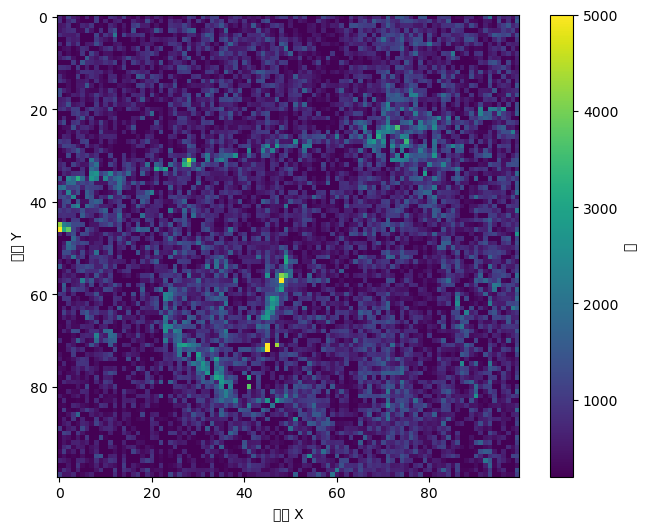

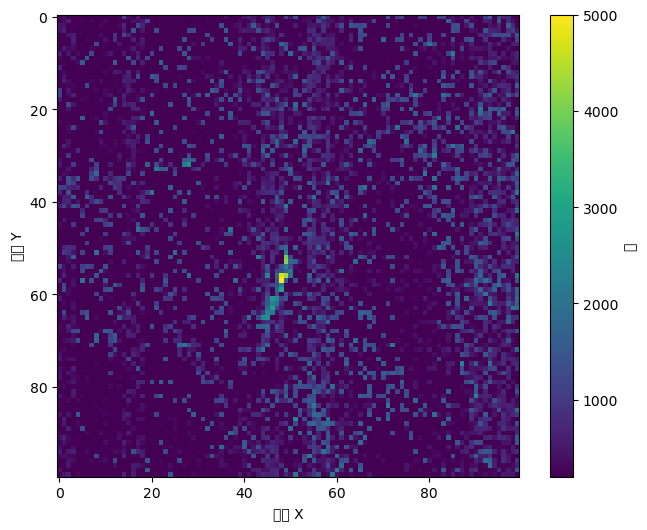

In [ ]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio import windows
import os

# 加载 .shp 文件中的点数据
shp_file = "/home/emeric/Documents/stanford/release_point.shp"
gdf = gpd.read_file(shp_file)

# 确保坐标参考系统与栅格影像一致
gdf = gdf.to_crs("EPSG:4326")  # 根据需要修改为栅格的坐标参考系统

# 读取 .tiff 文件
types = ["mf","cmlmf"]
for t in types:
    enmap_filepath = f"/home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR_{t}.tif"
    tiff_file = enmap_filepath
    with rasterio.open(tiff_file) as src:
        # 获取栅格数据的宽度、高度和坐标参考系统
        width = src.width
        height = src.height
        crs = src.crs
        transform = src.transform

        # 读取整个栅格数据为一个数组
        raster_data = src.read(1)  # 假设你只关心单波段数据
        # 设定切片的大小
        slice_size = 100

        # 创建输出文件夹
        output_dir = "/home/emeric/Documents/stanford/"
        os.makedirs(output_dir, exist_ok=True)

        # 遍历每个点，提取切片并保存为 npy 文件
        for idx, row in gdf.iterrows():
            # 获取点的坐标（经纬度）
            point = row.geometry
            lon, lat = point.x, point.y

            # 将点的坐标转换为栅格中的像素坐标
            col, row = ~transform * (lon, lat)

            # 计算切片的左上角和右下角坐标（确保切片在栅格范围内）
            half_size = slice_size // 2
            min_col = int(col - half_size)
            max_col = int(col + half_size)
            min_row = int(row - half_size)
            max_row = int(row + half_size)

            # 确保切片不会超出栅格范围
            min_col = max(0, min_col)
            max_col = min(width, max_col)
            min_row = max(0, min_row)
            max_row = min(height, max_row)

            # 提取切片区域
            window = windows.Window(min_col, min_row, max_col - min_col, max_row - min_row)
            slice_data = src.read(1, window=window)

            # 保存为 .npy 文件
            output_file = os.path.join(output_dir, f"Enmap_slice_{t}.npy")
            np.save(output_file, slice_data)
            # 绘制切片
            plt.figure(figsize=(8, 6))
            plt.imshow(slice_data, cmap='viridis',vmin=200,vmax=5000)
            plt.colorbar(label='值')
            plt.xlabel('像素 X')
            plt.ylabel(' Y')
            plt.show()



